In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.filters import cf_filter
dir = os.getcwd()

## 파이프라인
1. 샘플기간 PCA 후 성장지표 산정

1. 테스트기간 한 시점 추가될 때 마다 PCA 새로 진행 + 성장지표 새로 산정

1. new 성장지표 시계열로 CF 필터 적용

1. 국면 판단 진행: 결과 저장

-> 이 과정 쭉 반복

In [26]:
df = pd.read_csv(dir+'/data/merged.csv')

#날짜를 인덱스로 설정
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)
df1 = df.copy().dropna() #결측치 제거

#문자로 된 자료 숫자로 바꿔주기
for a in df1.columns:
    df1[a] = df1[a].astype('float')


#장단기 스프레드 // 출하지수-재고지수 스프레드
df1['y_spd'] = df1['10y'] - df1['3y']
df1['manu_spd'] = df1['shipment'] - df1['inven']
df1['manu_ratio'] = (df1['shipment'] / df1['inven'])-1 #스프레드하면 스케일이 약간 애매해져서, 양 지수에 로그취해서 빼줌

#설비투자전망지수 대기업+중소기업 평균 산출
df1['bsi_inv'] = (df1['bsi_inv_big'] + df1['bsi_inv_small']) / 2

#필요없는거 제거
df2 = df1.drop(columns=['bsi_inv_big', 'bsi_inv_small','10y', '3y', 'shipment', 'inven',
                        'wti','iron', 'copper', 'gold'])

#샘플기간 분리: 기준일 2017-07-01부터 out of sample
df2_train = df2['2003-02-01':'2017-06-01']
df2_test = df2['2017-07-01':]


#로그 씌우기
list_log = ['employ', 'durable', 'dubai', 'bsi_inv']
for a in list_log:
    df2[a+'_l'] = np.log(df2[a])

In [27]:
df2[['y_spd', 'manu_ratio', 'bsi_inv_l', 'employ_l', 'durable_l', 'dubai_l']].to_csv('log_merged.csv')

In [28]:
df2 = df2[['y_spd', 'manu_ratio', 'bsi_inv_l', 'employ_l', 'durable_l', 'dubai_l']]

df2_train = df2['2003-02-01':'2017-06-01']
df2_test = df2['2017-07-01':]

In [29]:
def pca(x):
    '''
    데이터프레임을 인풋으로
    PCA 결과들을 딕셔너리에 모아서 리턴해줌
    딕셔너리 키 목록
    1. df_scaled: 표준화된 데이터
    2. cov_matrix: 표준화된 데이터의 공분산 행렬
    3. eigenvalues_df: eigenvalues
    4. eigenvectors_df: eigenvectors
    5. explained_variance_ratio_df: 분산 설명비율
    '''
    scaler = StandardScaler() # standard normal
    df_scaled = scaler.fit_transform(x) #데이터 표준화
    cov_matrix = np.cov(df_scaled, rowvar=False) #공분산 행렬 계산
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix) #아이겐벡터, 밸류 계산
    principal_components = df_scaled.dot(eigenvectors[:, 0])  # 첫 번째 주성분(PC1)

    # PC1 방향을 나타내는 벡터
    pc1_vector = eigenvectors[:, 0]

    #Explained Variance Ratio
    explained_variance_ratio = eigenvalues / np.sum(eigenvalues)

    #PCA 결과 저장
    index = []
    for i in range(0,len(x.columns)):
        index.append(f'PC{i+1}')

    cov_matrix_df = pd.DataFrame(cov_matrix, columns=x.columns, index=x.columns)
    eigenvalues_df = pd.DataFrame({'Eigenvalues': eigenvalues}, index=index)
    eigenvectors_df = pd.DataFrame(eigenvectors, columns=index,
                                index=x.columns)
    explained_variance_ratio_df = pd.DataFrame({'Explained Variance Ratio': explained_variance_ratio},
                                            index=index)
    result = {'df_scaled' : df_scaled,
              'cov_matrix' : cov_matrix,
              'eigenvalues' : eigenvalues_df,
              'eigenvectors' : eigenvectors_df,
              'explained_variance' : explained_variance_ratio_df}
    print(result.keys())
    return result

In [30]:
CF_LOW, CF_HIGH = 18, 96
CF_DRIFT = True  # 랜덤워크+드리프트 가정

def cf_cycle(series, low=CF_LOW, high=CF_HIGH, drift=CF_DRIFT):
    s = pd.to_numeric(series, errors='coerce')
    cyc, _trend = cf_filter.cffilter(s, low=low, high=high, drift=drift)
    return pd.Series(cyc, index=s.index, name=series.name)

def zscore(series):
    mu, sd = series.mean(), series.std(ddof=0)
    return (series - mu) / sd

In [31]:
cf_ex = cf_filter.cffilter(df2_train, low=18, high=96, drift=True)[0]

In [32]:
type(cf_ex)


pandas.core.frame.DataFrame

In [54]:
# === 블록13: 2연속 규칙 기반 실시간 극점 탐지(룩어헤드 無, 수정판) ===
def detect_extrema_rule2(series: pd.Series,
                         halflife: float = 0.0,   # 0이면 스무딩 없음
                         min_gap: int = 4,        # 극점 간 최소 간격(개월)
                         prom_k: float = 0.0,     # 프로미넌스: 과거 σ의 k배 이상만 채택(0이면 미적용)
                         roll_std_win: int = 60,  # σ 계산 창
                         deadband_k: float = 0.0, # 변화가 너무 미세하면 0으로 취급(Δ의 σ 대비 k배)
                         deadband_win: int = 24):
    """
    피크 at t   : Δ_{t-2} > 0  and Δ_{t-1} < 0 and Δ_{t} < 0
    트로프 at t : Δ_{t-2} < 0  and Δ_{t-1} > 0 and Δ_{t} > 0
    확정 시점은 t (두 번째 감소/증가가 관측된 달). 미래 정보 사용 없음.
    """
    x = series.ewm(halflife=halflife, adjust=False).mean() if (halflife and halflife > 0) else series.copy()

    d = x.diff()

    # 데드밴드: Δ의 롤링 표준편차 기반 임계값
    if deadband_k > 0:
        d_std = d.rolling(deadband_win, min_periods=max(4, deadband_win//3)).std()
        thr = deadband_k * d_std
        # 부호 결정
        sign = np.where(d > thr,  1, np.where(d < -thr, -1, 0))
    else:
        sign = np.sign(d.values)

    sign = pd.Series(sign, index=d.index)

    # 프로미넌스 계산용 과거 σ
    roll_std = x.rolling(roll_std_win, min_periods=max(6, roll_std_win//3)).std()

    events = []
    last_idx = -10_000
    last_peak_level = None
    last_trough_level = None

    for i in range(2, len(x)):
        # 최소 간격
        if i - last_idx < min_gap:
            continue

        s2 = sign.iloc[i-2]  # Δ_{t-2}
        s1 = sign.iloc[i-1]  # Δ_{t-1}
        s0 = sign.iloc[i]    # Δ_{t}

        is_peak   = (s2 > 0) and (s1 < 0) and (s0 < 0)
        is_trough = (s2 < 0) and (s1 > 0) and (s0 > 0)
        if not (is_peak or is_trough):
            continue

        # 프로미넌스 필터
        if prom_k > 0:
            sigma_t = float(roll_std.iloc[:i].iloc[-1]) if not roll_std.iloc[:i].empty else float(x.std())
            sigma_t = sigma_t if sigma_t > 0 else float(x.std())
            if is_peak and (last_trough_level is not None):
                if (x.iloc[i] - last_trough_level) < prom_k * sigma_t:
                    continue
            if is_trough and (last_peak_level is not None):
                if (last_peak_level - x.iloc[i]) < prom_k * sigma_t:
                    continue

        ev_type = "peak" if is_peak else "trough"
        events.append({"date": x.index[i], "type": ev_type, "level": float(x.iloc[i])})
        last_idx = i
        if is_peak:
            last_peak_level = float(x.iloc[i])
        else:
            last_trough_level = float(x.iloc[i])

    events_df = pd.DataFrame(events).set_index("date") if events else pd.DataFrame(columns=["type","level"])
    out = {
        "series_used": x,
        "diff": d,
        "events_df": events_df
    }
    return out

In [55]:
cf_cycle = cf_filter.cffilter(df2_test, low=18, high=96, drift=True)[0]

In [56]:
cf_cycle

,y_spd_cycle,manu_ratio_cycle,bsi_inv_l_cycle,employ_l_cycle,durable_l_cycle,dubai_l_cycle
date,,,,,,
2017-07-01,0.001600,0.013025,0.010430,0.005078,-0.008805,0.005758
2017-08-01,-0.000155,0.012737,0.014004,0.005590,-0.006775,0.040110
2017-09-01,-0.000796,0.011431,0.017195,0.005981,-0.004410,0.076190
2017-10-01,-0.000558,0.009059,0.019622,0.006214,-0.001898,0.112097
2017-11-01,0.000160,0.005669,0.020964,0.006260,0.000552,0.145986
...,...,...,...,...,...,...
2025-02-01,-0.003843,0.008800,-0.015983,-0.001472,-0.010279,-0.098007
2025-03-01,0.024009,0.014038,-0.019124,-0.001714,-0.007621,-0.113026
2025-04-01,0.050828,0.019757,-0.020771,-0.001918,-0.005634,-0.122883


In [82]:
dates = [] #결과저장: 날짜
states = [] #결과저장: 예측된 Regime State
dates_detected = []
types_detected = []


for i in range(0,len(df2_test.index)):
    time = df2_test.index[i] # 예측값 얻고 싶은 날짜
    temp = df2['2003-02-01':time] # 데이터셋 이름 바뀌면 이 부분 수정
    

    #PCA 진행
    pca_result = pca(temp) 

    #pca1의 주성분을 PC1, PC2, PC3로 설정
    #표준화된 X 랑 eigenvector 곱하기
    data_pc = pca_result['df_scaled']@pca_result['eigenvectors'][['PC1', 'PC2', 'PC3']]
    data_pc.index = temp.index
    # Growth indicator 산출하는 부분
    # 각 지표별 가중치 변경하려면 이 부분 수정하기
    w0 = pca_result['explained_variance']['Explained Variance Ratio'].iloc[0]
    w1 = pca_result['explained_variance']['Explained Variance Ratio'].iloc[0]
    w2 = pca_result['explained_variance']['Explained Variance Ratio'].iloc[0]

    data_pc['growth_indicator'] = data_pc['PC1']*w0 + data_pc['PC2']*w1 + data_pc['PC3']*w2

    #cf필터 적용
    data_pc['cf'] = cf_filter.cffilter(data_pc['growth_indicator'], low=18, high=96, drift=True)[0]

    regime_result = detect_extrema_rule2(data_pc['cf'])

    dates.append(time)
    states.append(regime_result['events_df'])
    regime_result['events_df'].index = pd.to_datetime(regime_result['events_df'].index)
    
    target_dates = [time, time + pd.DateOffset(months=-1), time + pd.DateOffset(months=-2)]
    for a in target_dates:
        if a in regime_result['events_df'].index:
            date = pd.to_datetime(a)
            dates_detected.append(date)
            types_detected.append(regime_result['events_df']['type'].loc[a])
            # types_detected.append(regime_result['events_df'])
    


dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_

In [83]:
dates_detected

[Timestamp('2018-03-01 00:00:00'),
 Timestamp('2018-04-01 00:00:00'),
 Timestamp('2018-05-01 00:00:00'),
 Timestamp('2018-10-01 00:00:00'),
 Timestamp('2019-09-01 00:00:00'),
 Timestamp('2019-09-01 00:00:00'),
 Timestamp('2019-09-01 00:00:00'),
 Timestamp('2019-10-01 00:00:00'),
 Timestamp('2020-11-01 00:00:00'),
 Timestamp('2020-12-01 00:00:00'),
 Timestamp('2020-12-01 00:00:00'),
 Timestamp('2022-10-01 00:00:00'),
 Timestamp('2022-11-01 00:00:00'),
 Timestamp('2024-01-01 00:00:00'),
 Timestamp('2024-01-01 00:00:00'),
 Timestamp('2024-07-01 00:00:00')]

In [84]:
types_detected

['trough',
 'trough',
 'trough',
 'peak',
 'trough',
 'trough',
 'trough',
 'trough',
 'peak',
 'peak',
 'trough',
 'trough',
 'trough',
 'peak',
 'peak',
 'trough']

In [85]:
detection_result = pd.DataFrame({'date': dates_detected, 'type': types_detected})

In [86]:
detection_result = detection_result.drop_duplicates('date')

In [87]:
detection_result.set_index('date', inplace=True)

In [88]:
detection_result

,type
date,
2018-03-01,trough
2018-04-01,trough
2018-05-01,trough
2018-10-01,peak
2019-09-01,trough
2019-10-01,trough
2020-11-01,peak
2020-12-01,peak
2022-10-01,trough


In [89]:
trough.values

array(['trough', 'trough', 'trough', 'trough', 'trough', 'trough',
       'trough', 'trough'], dtype=object)

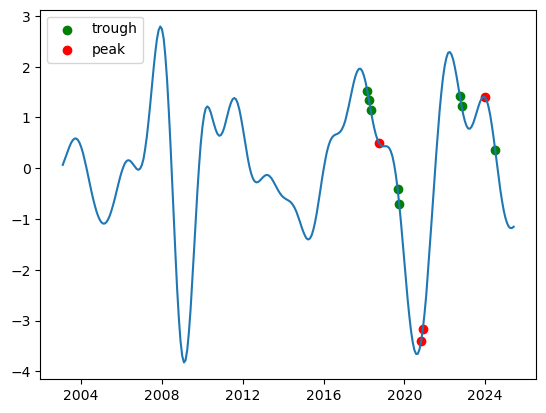

In [90]:
ipi = cf_filter.cffilter(df1['ipi'], low=18, high=96, drift=True)[0]
plt.plot(ipi)
peak = detection_result['type'].loc[detection_result['type']=='peak']
trough = detection_result['type'].loc[detection_result['type']=='trough']

plt.scatter(trough.index, ipi.loc[trough.index], color='green',label='trough')
plt.scatter(peak.index, ipi.loc[peak.index], color='red',label='peak')
plt.legend()


In [91]:
import FinanceDataReader as fdr
k200 = fdr.DataReader('KS200', '2003-02-01', '2025-06-30') # KOSPI 200 (KRX)
k200 = k200.asfreq('M', method='bfill')
k200.index = df1.index

C:\Users\tmdal\AppData\Local\Temp\ipykernel_24388\2195448399.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  k200 = k200.asfreq('M', method='bfill')


In [92]:
k200 = k200['Close']

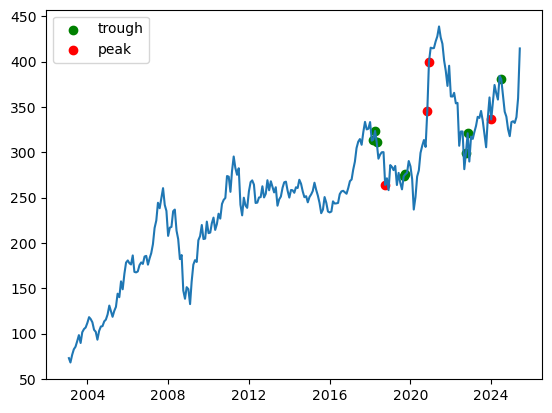

In [93]:
plt.plot(k200)
peak = detection_result['type'].loc[detection_result['type']=='peak']
trough = detection_result['type'].loc[detection_result['type']=='trough']

plt.scatter(trough.index, k200.loc[trough.index], color='green',label='trough')
plt.scatter(peak.index, k200.loc[peak.index], color='red',label='peak')
plt.legend()


In [102]:
msci = pd.read_csv(dir+'/data/msci.csv')

In [103]:
msci.set_index(pd.to_datetime(msci['date']), inplace=True)

In [104]:
msci.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14763 entries, 1969-01-01 to 2025-08-01
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      14763 non-null  object 
 1   korea     9807 non-null   float64
 2   growth    7459 non-null   float64
 3   value     7459 non-null   float64
 4   momentum  7873 non-null   float64
 5   quality   3146 non-null   float64
 6   lowvol    3255 non-null   float64
 7   highdiv   3146 non-null   float64
 8   small     8134 non-null   float64
dtypes: float64(8), object(1)
memory usage: 1.1+ MB


In [105]:
msci.asfreq('M', method='bfill')

C:\Users\tmdal\AppData\Local\Temp\ipykernel_24388\1548704376.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  msci.asfreq('M', method='bfill')


,date,korea,growth,value,momentum,quality,lowvol,highdiv,small
date,,,,,,,,,
1969-01-31,1969-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1969-02-28,1969-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1969-03-31,1969-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1969-04-30,1969-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1969-05-31,1969-06-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2025-03-31,2025-03-31,745.673,533.770,571.975,5871.668,4127.820,4977.797,6864.773,1631.190
2025-04-30,2025-04-30,753.421,545.471,571.623,6292.117,4181.418,5096.445,7077.941,1753.397
2025-05-31,2025-06-02,788.065,559.009,609.769,6852.203,4287.871,5236.891,7275.172,1927.268
